In [1]:
from utils import *
import pandas as pd
import pickle
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Stratified sampling

In [2]:
df_glob=pd.read_csv('outputs/df_glob.csv')
df_glob.head()

,user_id,top5community,cap,overall,fakefollower,spammer,astroturf,rnd_community
0,1011460081,RT5,0.721951,0.21,0.45,0.05,0.01,RT3
1,922804514960404480,RT1,0.522240,0.11,0.21,0.03,0.00,RT1
2,1128624948514381825,RT2,0.805309,0.65,0.46,0.21,0.12,RT2
3,971345562321784832,RT1,0.933842,0.99,0.46,0.05,0.17,RT1
4,2667821193,RT3,0.778449,0.28,0.09,0.00,0.27,RT1


In [3]:
#load botometer results
with open('outputs/results.dict','rb') as fi:
    results=pickle.load(fi)

We have to build a stratified sample of 160 users, following the distribution of the BotScore in the dataset. To do so, we need to count how many users fall in the intervals [0-0.1, 0.1-0.2,...1]. This is done in

In [ ]:
proportions=[x for x in df_glob[['user_id','overall']].groupby(pd.cut(df_glob[['user_id','overall']].overall, ranges)).count()['overall']/len(df_glob)]

where

In [ ]:
pd.cut(df_glob[['user_id','overall']].overall, ranges)

tells in which interval falls each id, then

In [ ]:
ranges = np.arange(start=0,stop=1.1, step=0.1)
[x for x in df_glob[['user_id','overall']].groupby(pd.cut(df_glob[['user_id','overall']].overall, ranges))] 

groups all users by the interval in which they fall.

Then we count, we take only 'overall' and we normalise over total to get the percentages.


In [ ]:
df_glob['class']=df_glob.overall.apply(lambda x: str(x)[2])
proba={k:v for k,v in zip(sorted(df_glob['class'].unique()),proportions)}

In [ ]:
n=159

ranges = np.arange(start=0,stop=1.1, step=0.1)
proportions=[x for x in df_glob[['user_id','overall']].groupby(pd.cut(df_glob[['user_id','overall']].overall, ranges)).count()['overall']/len(df_glob)]

sizes=[int(n*x) for x in proportions] #size of the classes in the final sample
print('expected sizes of sampled classes: {}'.format(sizes))

df_glob['class']=df_glob.overall.apply(lambda x: str(x)[2])
proba={k:v for k,v in zip(sorted(df_glob['class'].unique()),proportions)}#now each class will have a probability

user_ids={}
for i in df_glob['class'].unique():
    temp=df_glob[df_glob['class']==i]
    sel_temp=temp.sample(n=int(n*proba[i]),random_state=13) #for each class we take a sample of size n*proba[class]
    
    user_ids[i]=[x for x in sel_temp.user_id]

user_ids={k:user_ids[k] for k in sorted(user_ids.keys())} #{class:list of ids}

lens=[len(v) for v in user_ids.values()] #final sizes of the classes
print('actual sizes of sampled classes: {}'.format(lens))

botometer_subset={}
for k,v in user_ids.items():
    
    for i in v:
        botometer_subset[i]=results[str(i)]['raw_scores']['universal']['overall']

        

temp=pd.DataFrame.from_dict(botometer_subset,orient='index').reset_index()
temp=temp.rename(columns={'index':'user_id'})
temp['label']=pd.Series()


keys='resources/keys.txt'
ids=temp.user_id.astype(str)

names,exception=get_screenname(keys, ids)# from utils.py, gets Twitter screennames thorugh tweepy


temp['handles']=names

temp = temp.sample(frac=1).reset_index(drop=True)
print(temp)
#temp[['handles','label']].to_csv('user_ids.csv',index=False)

len(temp)

# Validation results

In [4]:
selected_users=pd.read_csv('resources/user_ids.csv').drop('label',axis=1) #set used for validation in the paper

c_dict={'human':'blue','cyborg':'pink','bot':'red'}


annot_users=pd.read_csv('resources/annotated_user_ids.csv') #labeled by me
annot_users=annot_users.merge(selected_users, on='handles')
annot_users=annot_users.drop('later_check',axis=1)
annot_users=annot_users[annot_users['label']!='unknown']
annot_users=annot_users[annot_users['handles']!='not_found']
annot_users['color_sal']=annot_users.label.map(c_dict)
annot_users=annot_users.sort_values('botscore')



alf_annot_users=pd.read_csv('resources/alf_annotated_user_ids.csv') #labeled by Alfonso


annot_users=annot_users.merge(alf_annot_users, on = 'handles',suffixes=('_sal','_alf')) #merge 
annot_users['color_alf']=annot_users.label_alf.map(c_dict)

jcr_annot_users=pd.read_csv('resources/gianca_annotated_user_ids.csv')# labeled by Giancarlo
jcr_annot_users=jcr_annot_users[['handles','label','botscore']]
jcr_annot_users=jcr_annot_users.rename(columns={'botscore':'new_botscore'})

annot_users=annot_users.merge(jcr_annot_users, on = 'handles',suffixes=('','_jcr')) #merge
annot_users['color_jcr']=annot_users.label_alf.map(c_dict)
annot_users=annot_users.rename(columns={'label':'label_jcr'})

annot_users=annot_users[['handles',  'botscore','new_botscore','label_sal', 'user_id', 'color_sal', 'label_alf',
       'color_alf', 'label_jcr', 'color_jcr']]
annot_users['new_botscore']=annot_users['new_botscore'].astype(float)/5

annot_users.head()

,handles,botscore,new_botscore,label_sal,user_id,color_sal,label_alf,color_alf,label_jcr,color_jcr
0,sebalestrieri,0.00,0.06,human,91145342,blue,human,blue,human,blue
1,rpapaposts,0.00,0.08,human,3063912850,blue,human,blue,human,blue
2,francescogonnos,0.00,0.04,human,150396008,blue,human,blue,human,blue
3,simpaol,0.01,0.04,human,454048091,blue,human,blue,human,blue
4,Paukzen,0.01,0.02,human,52001381,blue,human,blue,human,blue


In [5]:
print(pearsonr(annot_users['botscore'],annot_users['new_botscore']))
print(spearmanr(annot_users['botscore'],annot_users['new_botscore']))

(0.8373457441253542, 2.816162329381093e-38)
SpearmanrResult(correlation=0.7916725037657271, pvalue=1.5263472227281046e-31)


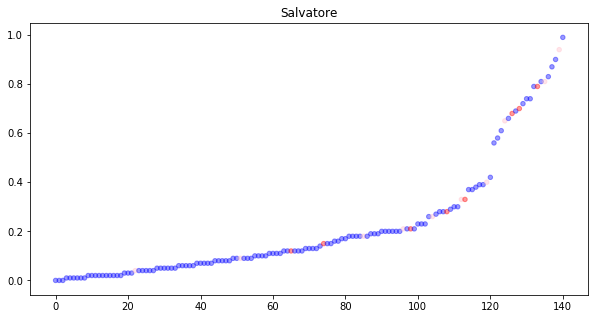

In [6]:
x=range(0,len(annot_users))
cols=[]

fig=plt.figure(figsize=(10,5))
plt.scatter(x,annot_users['botscore'],c=annot_users['color_sal'], alpha=0.4, s=20)
plt.title('Salvatore')
plt.show()

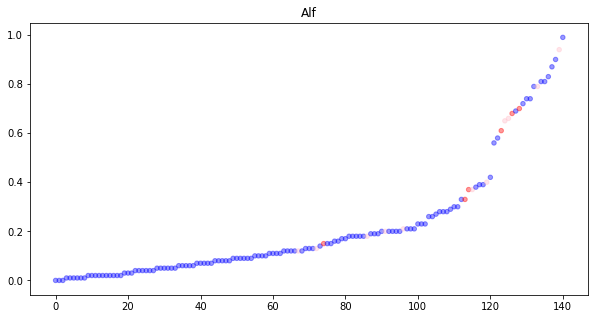

In [7]:
x=range(0,len(annot_users))
cols=[]

fig=plt.figure(figsize=(10,5))
plt.scatter(x,annot_users['botscore'],c=annot_users['color_alf'], alpha=0.4, s=20)
plt.title('Alf')
plt.show()

In [8]:
# setting definitive label by majority rule

final=[]

for i,row in annot_users.iterrows():
    if set([row['label_sal'],row['label_alf'],row['label_jcr']])==set(['human','human','human']):
        final.append('human')
    elif set([row['label_sal'],row['label_alf'],row['label_jcr']])==set(['human','human','cyborg']):
        final.append('human')
    elif set([row['label_sal'],row['label_alf'],row['label_jcr']])==set(['human','human','bot']):
        final.append('human')
    else:
        final.append('bot')

annot_users['three_annotators_class']=final
annot_users['three_annotators_colors']=annot_users['three_annotators_class'].map(c_dict)

annot_users

,handles,botscore,new_botscore,label_sal,user_id,color_sal,label_alf,color_alf,label_jcr,color_jcr,three_annotators_class,three_annotators_colors
0,sebalestrieri,0.00,0.06,human,91145342,blue,human,blue,human,blue,human,blue
1,rpapaposts,0.00,0.08,human,3063912850,blue,human,blue,human,blue,human,blue
2,francescogonnos,0.00,0.04,human,150396008,blue,human,blue,human,blue,human,blue
3,simpaol,0.01,0.04,human,454048091,blue,human,blue,human,blue,human,blue
4,Paukzen,0.01,0.02,human,52001381,blue,human,blue,human,blue,human,blue
...,...,...,...,...,...,...,...,...,...,...,...,...
136,janejane24,0.83,0.98,human,63764458,blue,human,blue,bot,blue,human,blue
137,AlfonsoGia,0.87,0.84,human,3313607731,blue,human,blue,bot,blue,human,blue
138,caterinarracci,0.90,0.88,human,245952640,blue,human,blue,human,blue,human,blue
139,maritozzo0,0.94,0.70,cyborg,968183123480662016,pink,cyborg,pink,cyborg,pink,bot,red


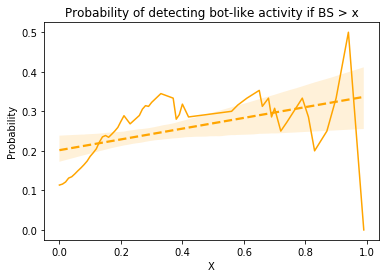

In [9]:
annot_users_bot=annot_users[annot_users['three_annotators_class']=='bot'] #bot only

x=annot_users.botscore.unique()
y=[]

for i in x:
    a=annot_users_bot[annot_users_bot['botscore']>=i] #change to < for CDF
    b=annot_users[annot_users['botscore']>=i]
    z=len(a)/len(b) #number of bots with bs > x / number of users with BS > x
    y.append(z)


sns.regplot(x,y ,scatter=False, color='orange',line_kws={'linestyle':'--'})
plt.plot(x,y,color='orange')

plt.title('Probability of detecting bot-like activity if BS > x')
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

In [ ]:
annot_users.to_csv('outputs/annot_users.csv',index=False)